In [1]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 16}
matplotlib.rc('font', **font)
from NODE_fns import NODE
from jax import grad, random, jit, jacobian, jacfwd
from functools import partial
import jax.example_libraries.optimizers as optimizers
from jax.lax import while_loop, fori_loop, scan
from jax.config import config
#config.update('jax_disable_jit', False)
config.update("jax_enable_x64", True)
import pickle
key = random.PRNGKey(0)

/Users/vt/miniforge3/envs/jax/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
with open('saved/params_jax.npy', 'rb') as f:
    params = pickle.load(f)
with open('saved/norm_w_jax.npy', 'rb') as f:
    inp_mean, inp_stdv, out_mean, out_stdv = pickle.load(f)

In [3]:
def dPhi(taui):
    NODE1_params, NODE2_params, NODE3_params, NODE4_params, NODE5_params = params
    
    tau1 = (taui[0] - inp_mean)/inp_stdv
    tau2 = (taui[1] - inp_mean)/inp_stdv
    tau3 = (taui[2] - inp_mean)/inp_stdv

    N1 = NODE(tau1, NODE1_params)
    N2 = NODE(tau1 + tau2, NODE2_params)
    N3 = NODE(tau1 + tau2 + tau3, NODE3_params)
    N4 = NODE(tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3, NODE4_params)
    N5 = NODE(tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3, NODE5_params)

    Phi1 = N1 + N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau1 - tau2 - tau3) #dphi/dtau1
    Phi2 =      N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau2 - tau1 - tau3)
    Phi3 =           N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau3 - tau1 - tau2)

    Phi1 = Phi1*out_stdv + out_mean
    Phi2 = Phi2*out_stdv + out_mean
    Phi3 = Phi3*out_stdv + out_mean
    return [Phi1, Phi2, Phi3]

d2Phi = jacobian(dPhi)

In [4]:
# Material parameters:
mu_m = np.array([51.4, -18, 3.86])
alpha_m = np.array([1.8, -2, 7])
K_m = 10000
tau = 17.5
shear_mod = 1/2*(mu_m[0]*alpha_m[0] + mu_m[1]*alpha_m[1] + mu_m[2]*alpha_m[2])
eta_D = tau*shear_mod
eta_V = tau*K_m
mu = 77.77 #=shear_mod
K = 10000

In [5]:
def evalGovindjee(dt, F, C_i_inv):
    #Preprocessing
    be_trial = np.dot(F, np.dot(C_i_inv, F.transpose()))
    lamb_e_trial, n_A = np.linalg.eigh(be_trial)
    n_A = np.real(n_A)
    lamb_e_trial = np.sqrt(np.real(lamb_e_trial))
    eps_e_trial = np.log(lamb_e_trial)
    eps_e = eps_e_trial #Initial guess for eps_e

    def iterate(inputs):
        normres, itr, eps_e, eps_e_trial, dt = inputs
        
        lamb_e = np.exp(eps_e)
        Je = lamb_e[0]*lamb_e[1]*lamb_e[2]
        bbar_e = Je**(-2/3)*lamb_e**2 #(54)

        b1 = bbar_e[0]
        b2 = bbar_e[1]
        b3 = bbar_e[2]

        #Calculate K_AB
        ddev11 = 0
        ddev12 = 0
        ddev13 = 0
        ddev22 = 0
        ddev23 = 0
        ddev33 = 0

        for r in range(3):
            e = alpha_m[r]/2
            ddev11 = ddev11 + mu_m[r]*(2*e)*( 4/9*b1**e + 1/9*(b2**e + b3**e)) #(B12)
            ddev22 = ddev22 + mu_m[r]*(2*e)*( 4/9*b2**e + 1/9*(b1**e + b3**e))
            ddev33 = ddev33 + mu_m[r]*(2*e)*( 4/9*b3**e + 1/9*(b1**e + b2**e))

            ddev12 = ddev12 + mu_m[r]*(2*e)*(-2/9*(b1**e + b2**e) + 1/9*b3**e) #(B13)
            ddev13 = ddev13 + mu_m[r]*(2*e)*(-2/9*(b1**e + b3**e) + 1/9*b2**e)
            ddev23 = ddev23 + mu_m[r]*(2*e)*(-2/9*(b2**e + b3**e) + 1/9*b1**e)
        ddev = np.array([[ddev11, ddev12, ddev13],[ddev12, ddev22, ddev23], [ddev13, ddev23, ddev33]])

        devtau1 = 0
        devtau2 = 0
        devtau3 = 0
        for r in range(3):
            e = alpha_m[r]/2
            devtau1 = devtau1 + mu_m[r]*(2/3*b1**e - 1/3*(b2**e + b3**e)) #(B8)
            devtau2 = devtau2 + mu_m[r]*(2/3*b2**e - 1/3*(b1**e + b3**e))
            devtau3 = devtau3 + mu_m[r]*(2/3*b3**e - 1/3*(b1**e + b2**e))
        devtau = np.array([devtau1, devtau2, devtau3])

        tau_NEQI = 3*K_m/2*(Je**2-1) #(B8)
        tau_A = devtau + 1/3*tau_NEQI #(B8)
        order = np.argsort(-tau_A)

        d2phid2tau = np.array(d2Phi(tau_A[order])) #Get the 2nd derivatives of Phi with NODEs

        dtaui_depsej = ddev + K_m*Je**2
        dtaui_depsej = dtaui_depsej[order] #-tau_A.argsort sorts descending order which is what I need.

        K_AB = np.eye(3) + dt*np.dot(d2phid2tau, dtaui_depsej)
        K_AB_inv = np.linalg.inv(K_AB)
        
        res = eps_e + dt*(1/2/eta_D*devtau + 1/9/eta_V*tau_NEQI*np.ones(3))-eps_e_trial #(60)
        deps_e = np.dot(K_AB_inv, -res)
        eps_e = eps_e + deps_e
        normres = np.linalg.norm(res)
        itr+= 1
        return [normres, itr, eps_e, eps_e_trial, dt]
    
    #Neuton Raphson
    normres = 1.0
    itr = 0
    itermax = 20
    cond_fun = lambda x: np.sign(x[0]-1.e-6) + np.sign(itermax - x[1]) > 0
    inps = while_loop(cond_fun, iterate, [normres,itr, eps_e, eps_e_trial, dt])
    normres, itr, eps_e, eps_e_trial, dt = inps
    # if normres>1.e-6:
    #     print('No local convergence')
    #     print(tau1, tau2, tau3)
    #     print(K_AB2)
    #     print(K_AB)
    # Now that the iterations have converged, calculate stress
    lamb_e = np.exp(eps_e)
    Je = lamb_e[0]*lamb_e[1]*lamb_e[2]
    bbar_e = Je**(-2/3)*lamb_e**2 #(54)

    b1 = bbar_e[0]
    b2 = bbar_e[1]
    b3 = bbar_e[2]

    devtau1 = 0
    devtau2 = 0
    devtau3 = 0
    for r in range(3):
        e = alpha_m[r]/2
        devtau1 = devtau1 + mu_m[r]*(2/3*b1**e - 1/3*(b2**e + b3**e)) #(B8)
        devtau2 = devtau2 + mu_m[r]*(2/3*b2**e - 1/3*(b1**e + b3**e))
        devtau3 = devtau3 + mu_m[r]*(2/3*b3**e - 1/3*(b1**e + b2**e))

    devtau = np.array([devtau1, devtau2, devtau3])

    tau_NEQI = 3*K_m/2*(Je**2-1) #(B8)
    tau_A = devtau + 1/3*tau_NEQI #(B8)
    tau_NEQ = tau_A[0]*np.outer(n_A[:,0], n_A[:,0]) + tau_A[1]*np.outer(n_A[:,1], n_A[:,1]) + tau_A[2]*np.outer(n_A[:,2], n_A[:,2]) #(58)
    b = np.dot(F,F.transpose())
    J = np.linalg.det(F)
    sigma_EQ = mu/J*(b-np.eye(3)) + 2*K*(J-1)*np.eye(3) #neo Hookean material
    sigma = 1/Je*tau_NEQ + sigma_EQ #(7)
    
    #Post processing
    be = np.einsum('i,ji,ki->jk', lamb_e**2, n_A, n_A)
    F_inv = np.linalg.inv(F)
    C_i_inv_new = np.dot(F_inv, np.dot(be, F_inv.transpose()))
    return sigma, C_i_inv_new, lamb_e

jitGovindjee = jit(evalGovindjee)

## 1 forward run

In [6]:
def gov_uniaxial():
    # Uniaxial tension in plane stress
    nsteps = 100

    sigma_x_vec = onp.zeros(nsteps)
    sigma_y_vec = onp.zeros(nsteps)
    sigma_z_vec = onp.zeros(nsteps)
    time    = onp.zeros(nsteps)
    dt      = 1.0

    # initial condition for viscous strains 
    C_i_inv   = onp.eye(3)
    for i in range(nsteps):
        if i<50:
            eps_x = i/nsteps+1e-6
        else:
            eps_x = 0.5
        sigma_y = 0.
        sigma_z = 0.
        normres = 1.0
        itr = 0
        itermax = 20
        eps_y = 0.0
        eps_z = 0.0
        while normres>1.e-6 and itr < itermax:
            lmx, lmy, lmz = 1+eps_x, 1+eps_y, 1+eps_z 
            F    = onp.array([[lmx,   0,    0], 
                              [0,    lmy,   0], 
                              [0,    0,   lmz]])
            sigma, C_i_inv_new, lamb_e = jitGovindjee(dt, F, C_i_inv)
            res = np.array([sigma[1,1]-sigma_y, sigma[2,2]-sigma_z])

            # calculate dres with NR 
            F_py = onp.array([[lmx,   0,    0], 
                              [0, lmy+1e-6, 0], 
                              [0,     0,  lmz]])
            F_pz = onp.array([[lmx,   0,    0], 
                              [0,    lmy  , 0], 
                              [0, 0, lmz+1e-6]])
            sigma_py, _, _ = jitGovindjee(dt, F_py, C_i_inv)
            sigma_pz, _, _ = jitGovindjee(dt, F_pz, C_i_inv)
            
            
            dres = onp.array([[(sigma_py[1,1]-sigma[1,1])/1e-6,(sigma_py[2,2]-sigma[2,2])/1e-6],\
                             [(sigma_pz[1,1]-sigma[1,1])/1e-6,(sigma_pz[2,2]-sigma[2,2])/1e-6]])
            
            deps = onp.linalg.solve(dres,-res)
            eps_y += deps[0]
            eps_z += deps[1]
            normres = onp.linalg.norm(res)
            itr+=1 
        lmx, lmy, lmz = 1+eps_x, 1+eps_y, 1+eps_z
        F = onp.array([[lmx,   0,    0], 
                       [0,    lmy,   0], 
                       [0,    0,   lmz]])
        sigma, C_i_inv_new, lamb_e = jitGovindjee(dt, F, C_i_inv)
        C_i_inv = C_i_inv_new
        sigma_x_vec[i] = sigma[0,0]
        sigma_y_vec[i] = sigma[1,1]
        sigma_z_vec[i] = sigma[2,2]
        time[i] = time[i-1] + dt
    return sigma_x_vec, sigma_y_vec, sigma_z_vec

In [ ]:
sigma_x_vec, sigma_y_vec, sigma_z_vec = gov_uniaxial()

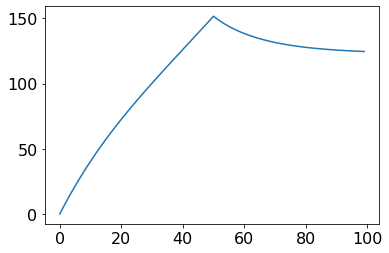

In [10]:
plt.plot(sigma_x_vec)

## Autodiff for residual

In [32]:
def residual(eps_x, eps_y, eps_z, C_i_inv, dt, sigma_y, sigma_z):
    F = np.array([[1+eps_x, 0, 0], [0, 1+eps_y, 0], [0, 0, 1+eps_z]])
    sigma, _, _ = evalGovindjee(dt, F, C_i_inv)
    res = np.array([sigma[1, 1]-sigma_y, sigma[2, 2]-sigma_z])
    return res


dresidual = jacfwd(residual, argnums=(1, 2))


def gov_uniaxial2():
    # Uniaxial tension in plane stress
    nsteps = 100

    sigma_x_vec = onp.zeros(nsteps)
    sigma_y_vec = onp.zeros(nsteps)
    sigma_z_vec = onp.zeros(nsteps)
    time = onp.zeros(nsteps)
    dt = 1.0

    # initial condition for viscous strains
    C_i_inv = onp.eye(3)
    for i in range(nsteps):
        if i < 50:
            eps_x = i/nsteps+1e-6
        else:
            eps_x = 0.5
        sigma_y = 0.
        sigma_z = 0.
        normres = 1.0
        itr = 0
        itermax = 20
        eps_y = 0.0
        eps_z = 0.0
        while normres > 1.e-6 and itr < itermax:
            lmx, lmy, lmz = 1+eps_x, 1+eps_y, 1+eps_z 
            F    = onp.array([[lmx,   0,    0], 
                              [0,    lmy,   0], 
                              [0,    0,   lmz]])
            sigma, C_i_inv_new, lamb_e = evalGovindjee(dt, F, C_i_inv)
            res =  onp.array([sigma[1, 1]-sigma_y, sigma[2, 2]-sigma_z])
            res2 = residual(eps_x, eps_y, eps_z, C_i_inv, dt, sigma_y, sigma_z)

            # calculate dres with NR
            F_py = onp.array([[lmx,   0,    0], 
                              [0, lmy+1e-6, 0], 
                              [0,     0,  lmz]])
            F_pz = onp.array([[lmx,   0,    0], 
                              [0,    lmy  , 0], 
                              [0, 0, lmz+1e-6]])
            sigma_py, _, _ = evalGovindjee(dt, F_py, C_i_inv)
            sigma_pz, _, _ = evalGovindjee(dt, F_pz, C_i_inv)

            dres = onp.array([[(sigma_py[1, 1]-sigma[1, 1])/1e-6, (sigma_py[2, 2]-sigma[2, 2])/1e-6],
                              [(sigma_pz[1, 1]-sigma[1, 1])/1e-6, (sigma_pz[2, 2]-sigma[2, 2])/1e-6]])
            dres2 = dresidual(eps_x, eps_y, eps_z, C_i_inv, dt, sigma_y, sigma_z)

            print(dres, dres2)
            deps = onp.linalg.solve(dres, -res)
            eps_y += deps[0]
            eps_z += deps[1]
            normres = onp.linalg.norm(res)
            itr += 1
        lmx, lmy, lmz = 1+eps_x, 1+eps_y, 1+eps_z
        F = onp.array([[lmx,   0,    0], 
                       [0,    lmy,   0], 
                       [0,    0,   lmz]])
        sigma, C_i_inv_new, lamb_e = evalGovindjee(dt, F, C_i_inv)
        C_i_inv = C_i_inv_new
        sigma_x_vec[i] = sigma[0, 0]
        sigma_y_vec[i] = sigma[1, 1]
        sigma_z_vec[i] = sigma[2, 2]
        time[i] = time[i-1] + dt
    return sigma_x_vec, sigma_y_vec, sigma_z_vec


In [ ]:
sigma_x_vec, sigma_y_vec, sigma_z_vec = gov_uniaxial2()

In [ ]:
plt.plot(sigma_x_vec)

## Biaxial

In [60]:
with open('training_data/gov_data.npy','rb') as f:
    time, eps_x, eps_y, sigma_x, sigma_y = np.load(f)
time = time[:200]

In [51]:
def gov_biaxial(eps_x, eps_y, dt=1.0):
    nsteps = eps_x.shape[0]

    sigma_x_vec = onp.zeros(nsteps)
    sigma_y_vec = onp.zeros(nsteps)
    sigma_z_vec = onp.zeros(nsteps)
    time    = onp.zeros(nsteps)

    # initial condition for viscous strains 
    C_i_inv   = onp.eye(3)
    for i in range(nsteps):
        sigma_z = 0.
        normres = 1.0
        itr = 0
        itermax = 20
        eps_z = 0.0
        while normres>1.e-6 and itr < itermax:
            lmx, lmy, lmz = 1+eps_x[i], 1+eps_y[i], 1+eps_z 
            F    = onp.array([[lmx,   0,    0], 
                              [0,    lmy,   0], 
                              [0,    0,   lmz]])
            sigma, C_i_inv_new, lamb_e = evalGovindjee(dt, F, C_i_inv)
            res  = sigma[2,2]-sigma_z

            # calculate dres with NR 
            F_pz = onp.array([[lmx,   0,    0], 
                              [0,    lmy,   0], 
                              [0,  0,lmz+1e-6]])
            sigma_pz, _, _ = evalGovindjee(dt, F_pz, C_i_inv)
            
            dres = (sigma_pz[2,2]-sigma[2,2])/1e-6
            
            deps = -res/dres
            eps_z += deps
            normres = onp.linalg.norm(res)
            itr+=1 
        lmx, lmy, lmz = 1+eps_x[i], 1+eps_y[i], 1+eps_z
        F = onp.array([[lmx,   0,    0], 
                       [0,    lmy,   0], 
                       [0,    0,   lmz]])
        sigma, C_i_inv_new, lamb_e = evalGovindjee(dt, F, C_i_inv)
        C_i_inv = C_i_inv_new
        sigma_x_vec[i] = sigma[0,0]
        sigma_y_vec[i] = sigma[1,1]
        sigma_z_vec[i] = sigma[2,2]
        time[i] = time[i-1] + dt
    return sigma_x_vec, sigma_y_vec, sigma_z_vec

In [52]:
sigma_x_vec, sigma_y_vec, sigma_z_vec = gov_biaxial(eps_x[:200], eps_y[:200]) 

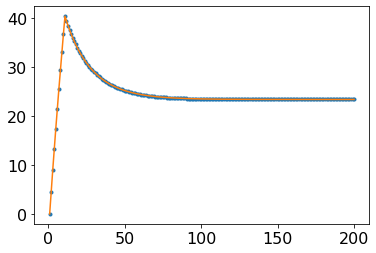

In [62]:
fig, ax = plt.subplots()

ax.plot(time[:200], sigma_x[:200], '.')
ax.plot(time[:200], sigma_x_vec)

## Outer loop in jax

In [21]:
def outerloop(inputs):
    normres, itr, eps_x, eps_y, eps_z, sigma_y, sigma_z, C_i_inv, dt = inputs
    lmx, lmy, lmz = 1+eps_x, 1+eps_y, 1+eps_z 
    F    = np.array([[lmx,   0,    0], 
                     [0,    lmy,   0], 
                     [0,    0,   lmz]])
    sigma, C_i_inv_new, lamb_e = evalGovindjee(dt, F, C_i_inv)
    res = np.array([sigma[1,1]-sigma_y, sigma[2,2]-sigma_z])

    # calculate dres with NR 
    F_py = np.array([[lmx,   0,    0], 
                     [0, lmy+1e-6, 0], 
                     [0,     0,  lmz]])
    F_pz = np.array([[lmx,   0,    0], 
                     [0,    lmy  , 0], 
                     [0, 0, lmz+1e-6]])
    sigma_py, _, _ = evalGovindjee(dt, F_py, C_i_inv)
    sigma_pz, _, _ = evalGovindjee(dt, F_pz, C_i_inv)
    
    
    dres = np.array([[(sigma_py[1,1]-sigma[1,1])/1e-6,(sigma_py[2,2]-sigma[2,2])/1e-6],\
                        [(sigma_pz[1,1]-sigma[1,1])/1e-6,(sigma_pz[2,2]-sigma[2,2])/1e-6]])
    
    deps = np.linalg.solve(dres,-res)
    eps_y += deps[0]
    eps_z += deps[1]
    normres = np.linalg.norm(res)
    itr+=1 
    return [normres, itr, eps_x, eps_y, eps_z, sigma_y, sigma_z, C_i_inv, dt]

def timeloop(C_i_inv, eps_x):
    dt = 1.0
    normres = 1.0
    itr = 0
    itermax = 20
    cond_fun = lambda x: np.sign(x[0]-1.e-6) + np.sign(itermax - x[1]) > 0
    inputs = while_loop(cond_fun, outerloop, [normres,itr, eps_x, 0.0, 0.0, 0.0, 0.0, C_i_inv, dt])
    normres, itr, eps_x, eps_y, eps_z, sigma_y, sigma_z, C_i_inv, dt = inputs
    
    lmx, lmy, lmz = 1+eps_x, 1+eps_y, 1+eps_z
    F = np.array([[lmx,   0,    0], 
                  [0,    lmy,   0], 
                  [0,    0,   lmz]])
    sigma, C_i_inv_new, lamb_e = evalGovindjee(dt, F, C_i_inv)
    return C_i_inv_new, sigma

@jit
def gov_uniaxial():
    nsteps = 100

    C_i_inv = np.eye(3)
    eps_x1  = np.linspace(1e-6,0.5,int(nsteps/2))
    eps_x2  = np.ones(int(nsteps/2))*0.5
    eps_x   = np.hstack((eps_x1, eps_x2))

    C_i_inv, sigma_vec = scan(timeloop, C_i_inv, eps_x)
    
    return sigma_vec

In [26]:
sigma_vec = gov_uniaxial()

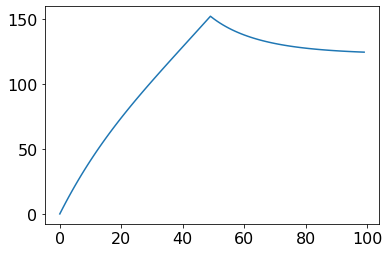

In [27]:
plt.plot(sigma_vec[:,0,0])

## Biaxial

In [37]:
def outerloop(inputs):
    res, itr, eps_x, eps_y, eps_z, sigma_y, sigma_z, C_i_inv, dt = inputs
    lmx, lmy, lmz = 1+eps_x, 1+eps_y, 1+eps_z 
    F    = np.array([[lmx,   0,    0], 
                     [0,    lmy,   0], 
                     [0,    0,   lmz]])
    sigma, C_i_inv_new, lamb_e = evalGovindjee(dt, F, C_i_inv)
    res = sigma[2,2]-sigma_z

    # calculate dres with NR 
    F_pz = np.array([[lmx,   0,    0], 
                     [0,    lmy  , 0], 
                     [0, 0, lmz+1e-6]])
    sigma_pz, _, _ = evalGovindjee(dt, F_pz, C_i_inv)
    
    dres = (sigma_pz[2,2]-sigma[2,2])/1e-6
    
    deps = -res/dres
    eps_z += deps
    itr+=1 
    return [res, itr, eps_x, eps_y, eps_z, sigma_y, sigma_z, C_i_inv, dt]

def timeloop(C_i_inv, data):
    eps_x, eps_y, dt = data
    res = 1.0
    itr = 0
    itermax = 20
    cond_fun = lambda x: np.sign(x[0]-1.e-6) + np.sign(itermax - x[1]) > 0
    inputs = while_loop(cond_fun, outerloop, [res,itr, eps_x, eps_y, 0.0, 0.0, 0.0, C_i_inv, dt])
    normres, itr, eps_x, eps_y, eps_z, sigma_y, sigma_z, C_i_inv, dt = inputs
    
    lmx, lmy, lmz = 1+eps_x, 1+eps_y, 1+eps_z
    F = np.array([[lmx,   0,    0], 
                  [0,    lmy,   0], 
                  [0,    0,   lmz]])
    sigma, C_i_inv_new, lamb_e = evalGovindjee(dt, F, C_i_inv)
    return C_i_inv_new, sigma

@jit
def gov_biaxial(eps_x, eps_y, dt):
    dt = np.ones_like(eps_x)*dt
    C_i_inv = np.eye(3)
    C_i_inv, sigma_vec = scan(timeloop, C_i_inv, [eps_x, eps_y, dt])
    
    return sigma_vec

In [38]:
with open('training_data/gov_data.npy','rb') as f:
    time, eps_x, eps_y, sigma_x, sigma_y = np.load(f)
time = time[:200]

In [47]:
sigma_pr = gov_biaxial(eps_x[:200], eps_y[:200], 1.0) 

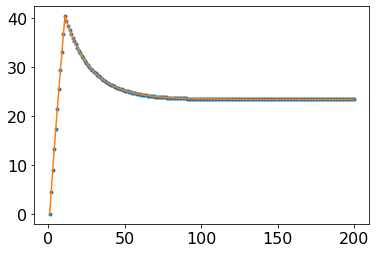

In [48]:
fig, ax = plt.subplots()

ax.plot(time[:200], sigma_x[:200], '.')
ax.plot(time[:200], sigma_pr[:,0,0])